
政策关键词时间演化统计：
       创新   技术  产业
2012   78   14   1
2016   79   24   3
2017   20   33   3
2018    3   10   0
2019   23   25  11
2020    3   10   0
2021  103  185  18
2022   71  177   4
2023   12   41   7
2024   26   17  18
关键词 '创新' 的趋势检验结果: 趋势 = no trend, p = 0.7876
关键词 '技术' 的趋势检验结果: 趋势 = no trend, p = 0.4190
关键词 '产业' 的趋势检验结果: 趋势 = no trend, p = 0.0854

政策工具统计：
   供给型  环境型  需求型  year
0    6    2    0  2012
1    6    1    0  2016
2    4    2    8  2017
3    0    0    0  2018
4    4    1    1  2019
5    1    0    0  2020
6   23    5    2  2021
7   19    2    3  2022
8    5    2    1  2023
9    1    2    1  2024


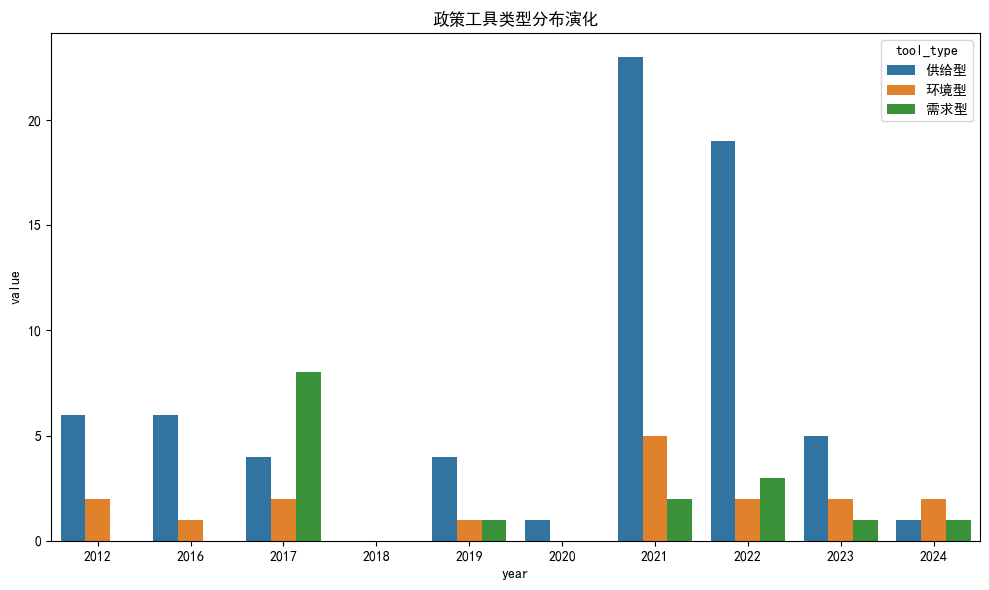

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\12914\AppData\Local\Temp\jieba.cache
Loading model cost 0.602 seconds.
Prefix dict has been built successfully.


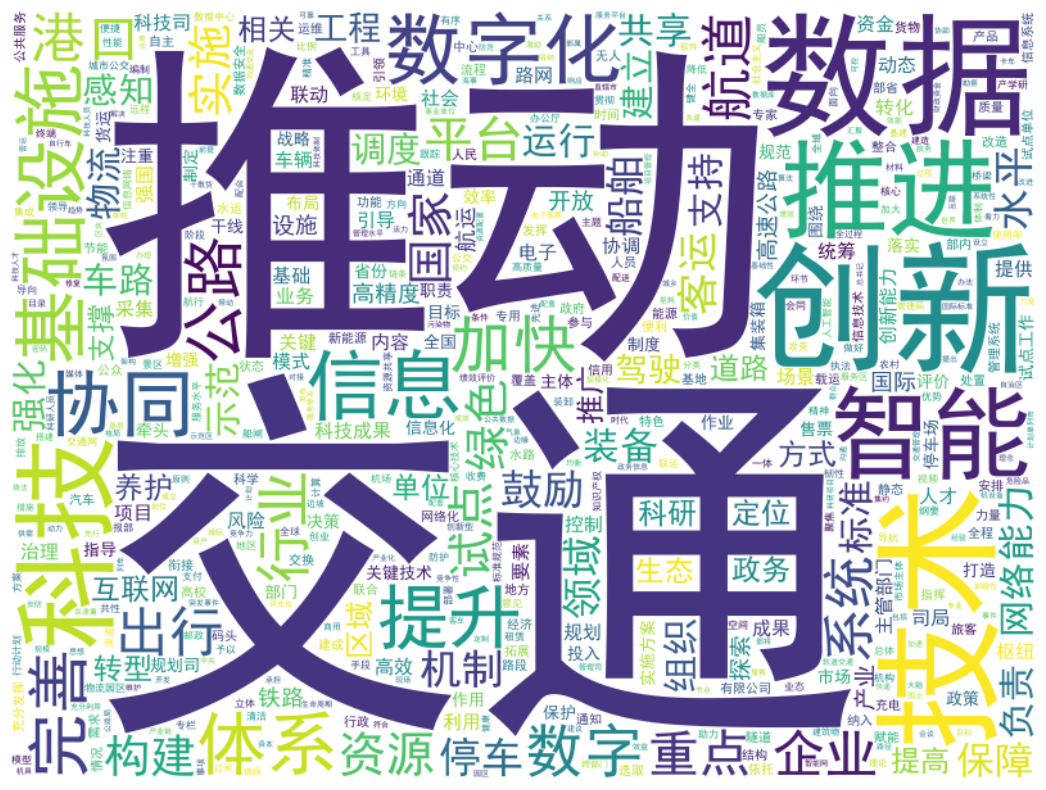

社区结果：
社区 1: frozenset({'港口', '能力', '示范', '标准', '调度', '感知', '工程', '交通', '重点', '铁路', '共享', '驾驶', '车路', '实施', '航道', '组织', '网络', '绿色', '船舶', '方式', '生态'})
社区 2: frozenset({'体系', '基础设施', '系统', '推进', '数字化', '加快', '技术', '转型', '提升', '构建', '养护', '数字', '完善', '公路', '协同', '智能', '定位'})
社区 3: frozenset({'领域', '企业', '投入', '支持', '保障', '科技', '人才', '装备', '创新', '科技成果', '转化', '机制', '科研', '创新能力', '行业'})
社区 4: frozenset({'科技司', '数据', '司局', '负责', '资源', '国家', '职责', '平台', '牵头', '政务'})
社区 5: frozenset({'鼓励', '物流', '出行', '运行', '客运', '信息', '售票', '水平', '推动', '道路'})
社区 6: frozenset({'试点工作', '景区', '便利', '停车场', '试点', '静态', '停车'})


C:\Users\12914\AppData\Local\Temp\ipykernel_16408\3915691094.py:244: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_comms)


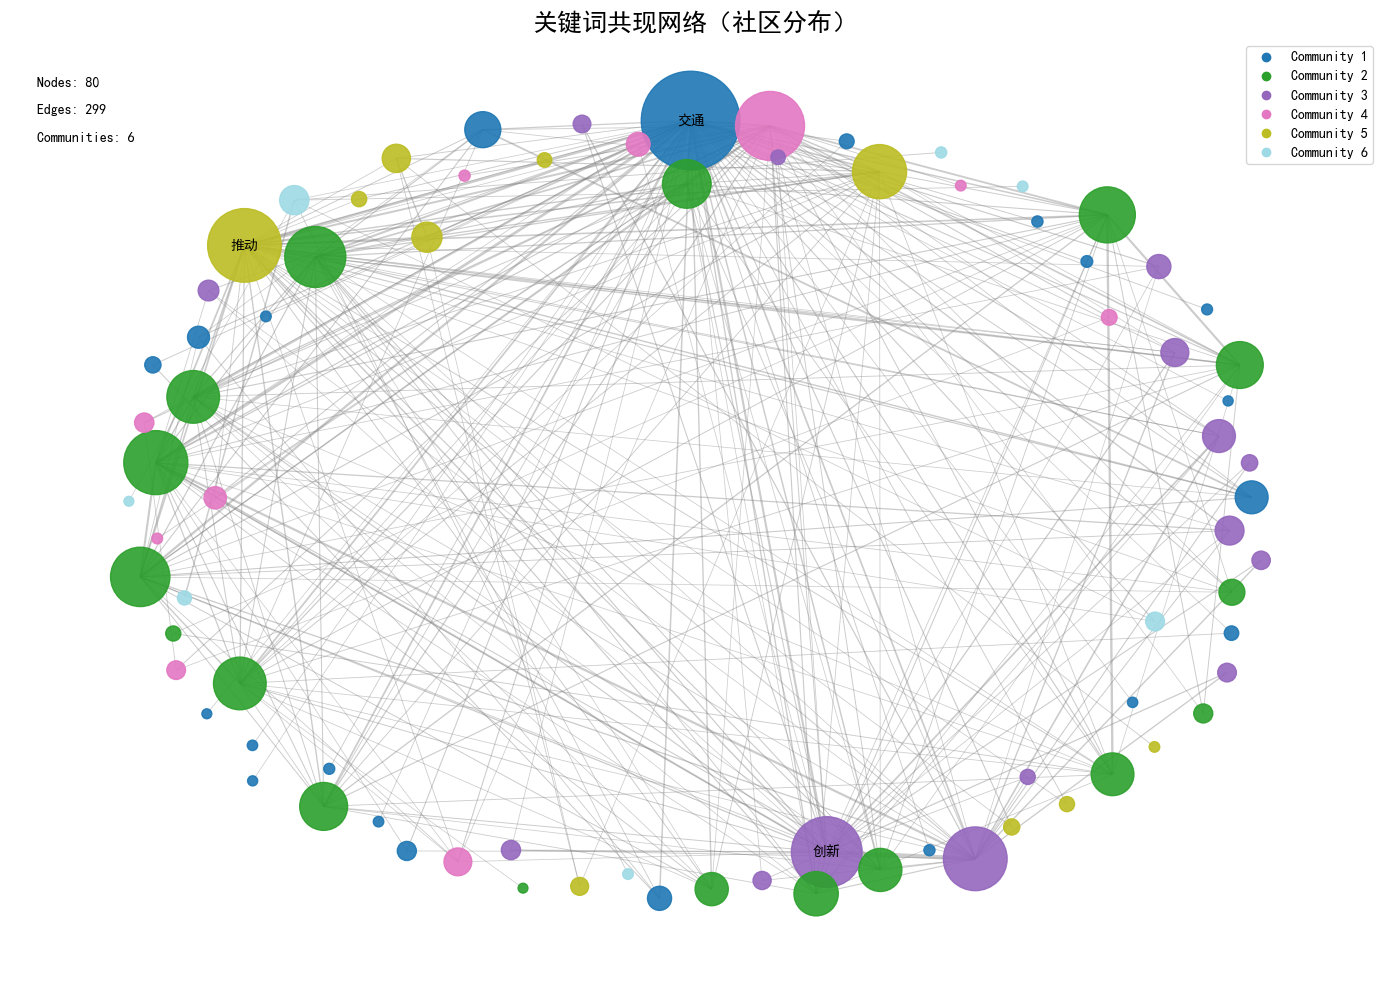

In [1]:
import os
import re
import glob
import jieba
import jieba.posseg as pseg
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pymannkendall as mk
from wordcloud import WordCloud
import networkx as nx
import matplotlib
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# 设置中文字体和允许负号显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# 全局变量定义
POLICIES_FOLDER = '../data/policy_ch1_bg'
STOPWORDS_FOLDER = '../data/texts/stopwords'
# 结果输出统一目录
OUTPUT_FOLDER = './output'
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# ------------------------------
# 1. 数据加载与预处理
# ------------------------------
def load_policies(folder_path=POLICIES_FOLDER):
    """
    加载所有政策文本文件，返回：{年份: {文件名: 文本内容}}
    如果文件名中未能提取到4位年份，则该文件归为 'unknown'
    """
    policies = defaultdict(dict)
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            year_list = re.findall(r'\d{4}', file)
            year = int(year_list[0]) if year_list else "unknown"
            with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
                policies[year][file] = f.read()
    return policies

def load_stopwords_from_folder(folder_path=STOPWORDS_FOLDER):
    """
    从指定文件夹中加载所有txt文件作为停用词库，并合并为一个集合。
    每个文件中的每行应包含一个停用词。
    """
    stopwords = set()
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            file_path = os.path.join(folder_path, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                stopwords.update({line.strip() for line in f if line.strip()})
    return stopwords

STOPWORDS = load_stopwords_from_folder()

# ------------------------------
# 2. 文本分词与主题提取
# ------------------------------
# 定义政策工具关键词词典
tool_dict = {
    '供给型': [
        '研发补贴', '人才培养', '基础设施建设', '技术标准', '科研机构', 
        '专项资金支持', '创新平台', '科技园区', '产学研合作', '实验室建设',
        '产业联盟', '高端人才引进', '技术攻关'
    ],
    '环境型': [
        '税收优惠', '法规', '牌照发放', '安全监管', '数据隐私', 
        '碳交易政策', '知识产权保护', '金融支持', '行业准入标准', '绿色认证',
        '能源补贴', '政府投资', '标准化建设'
    ],
    '需求型': [
        '政府采购', '场景开放', '示范应用', '市场准入', '消费补贴', 
        '用户补贴', '推广激励', '市场推广支持', '试点示范', '用户体验优化',
        '产业链合作', '商用试点', '大规模推广'
    ]
}

def policy_tool_analysis(text):
    """
    政策工具分类统计，返回各类工具出现的次数（不区分大小写匹配）
    """
    counts = {key: 0 for key in tool_dict}
    for tool_type, keywords in tool_dict.items():
        for kw in keywords:
            counts[tool_type] += len(re.findall(kw, text, flags=re.IGNORECASE))
    return counts

# ------------------------------
# 3. 时间序列统计与趋势分析
# ------------------------------
def temporal_analysis(policies, target_keywords):
    """
    政策关键词时间演化分析，返回 DataFrame（年份 x 关键词词频）
    """
    df = pd.DataFrame()
    for year, files in policies.items():
        if isinstance(year, int):
            year_counts = defaultdict(int)
            for text in files.values():
                for kw in target_keywords:
                    year_counts[kw] += len(re.findall(kw, text))
            df = pd.concat([df, pd.DataFrame(year_counts, index=[year])])
    df = df.sort_index()
    return df

def trend_test(series):
    """
    Mann-Kendall 趋势检验，返回字典 {'trend': 趋势描述, 'p': p值}
    """
    result = mk.original_test(series)
    return {'trend': result.trend, 'p': result.p}

# ------------------------------
# 4. 实体抽取与共现网络构建
# ------------------------------
# 设置实体抽取规则
entity_patterns = {
    'government': r'\b(?:工信部|交通运输部|发改委|(?:市(?:政府|委)))\b',
    'enterprise': r'\b(?:百度|蔚来|特斯拉|华为|阿里巴巴|腾讯|中兴)\b',
    'academia': r'\b(?:清华大学|北京大学|中科院|高校|复旦大学|上海交通大学)\b'
}

def extract_entities(text):
    """
    从文本中抽取不同类型实体，返回字典，键为实体类型，值为匹配到的实体列表
    """
    entities = defaultdict(list)
    for ent_type, pattern in entity_patterns.items():
        entities[ent_type] = re.findall(pattern, text)
    return entities

def build_co_occurrence(text, window_size=5):
    """
    构建给定文本的共现网络（基于滑动窗口），返回共现词对及其出现次数
    """
    words = jieba.lcut(text)
    co_occur = defaultdict(int)
    for i in range(len(words)):
        for j in range(i + 1, min(i + window_size, len(words))):
            pair = tuple(sorted([words[i], words[j]]))
            co_occur[pair] += 1
    return co_occur

# ------------------------------
# 5. 耦合协调度模型
# ------------------------------
def coupling_coordination(policy_score, tech_score, social_score):
    """
    计算耦合协调度模型，输入为政策、技术、社会三个部分的指标（数值型）。
    首先采用 Min-Max 标准化后计算耦合度。
    """
    scaler = MinMaxScaler()
    combined = np.array([policy_score, tech_score, social_score])
    scaled = scaler.fit_transform(combined)
    P, T, S = scaled.flatten()
    if (P + T) == 0 or (P + S) == 0 or (T + S) == 0:
        return 0
    D = np.sqrt((P * T / (P + T)) * (P * S / (P + S)) * (T * S / (T + S)))
    return D

# ------------------------------
# 6. 数据预处理：文本清洗
# ------------------------------
def text_cleaning(text):
    """
    清洗文本，去除除中文、英文、数字以外的字符，并利用 jieba 分词过滤停用词（保留名词、动词、形容词）
    """
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9]', ' ', text)
    words = pseg.cut(text)
    filtered_words = [word.word for word in words if word.flag in ['n', 'v', 'a'] and word.word not in STOPWORDS]
    return ' '.join(filtered_words)

# ------------------------------
# 7. 可视化模块
# ------------------------------
def visualize_policy_tools(tool_df):
    """
    利用 Seaborn 绘制政策工具类型分布演化图
    """
    df_melt = pd.melt(tool_df, id_vars=['year'], value_vars=['供给型', '环境型', '需求型'],
                      var_name='tool_type', value_name='value')
    plt.figure(figsize=(10, 6))
    sns.barplot(x='year', y='value', hue='tool_type', data=df_melt)
    plt.title("政策工具类型分布演化")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_FOLDER, "policy_tools_evolution.png"), dpi=300)
    plt.show()

def generate_wordcloud_from_frequencies(frequencies, output_filename='policy_wordcloud.png', width=800, height=600):
    """
    根据关键词频率生成词云图，不使用mask，支持设置输出图片路径
    """
    font_path = r"C:\Windows\Fonts\simhei.ttf"
    wc = WordCloud(
        background_color='white',
        max_words=500,
        contour_width=3,
        contour_color='steelblue',
        font_path=font_path,
        width=width,
        height=height,
    )
    wc.generate_from_frequencies(frequencies)
    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    output_path = os.path.join(OUTPUT_FOLDER, output_filename)
    plt.savefig(output_path, dpi=300)
    plt.show()

def draw_static_network_improved(G, top_label_num=20, k=2.0, output_filename='co_occurrence_network_improved.png'):
    """
    改进版静态共现网络图：
      - 通过贪婪模块度方法检测社区，并为每个社区分配不同颜色；
      - 仅显示度数排名前 top_label_num 的节点标签；
      - 使用 spring_layout 布局并调大 k 值拉大节点间距；
      - 调整边宽和节点大小，使整体效果更美观；
      - 添加图例显示社区颜色对应关系，并显示图统计信息；
      - 输出社区结果和网络图到统一结果目录。
    """
    # 计算节点度分布
    degree = dict(G.degree(weight='weight'))
    # 检测社区（使用贪婪模块度算法）
    communities = list(nx.algorithms.community.greedy_modularity_communities(G))
    print("社区结果：")
    for i, comm in enumerate(communities):
        print(f"社区 {i + 1}: {comm}")
    # 为每个节点分配社区ID
    node_community = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            node_community[node] = idx
    num_comms = len(communities)
    # 定义节点颜色映射，使用 matplotlib 的 colormap
    cmap = cm.get_cmap('tab20', num_comms)
    node_colors = [cmap(node_community[node]) for node in G.nodes()]
    # 选取部分度较高的节点用于显示标签
    sorted_nodes = sorted(degree.items(), key=lambda x: x[1], reverse=True)
    label_nodes = {node for node, _ in sorted_nodes[:top_label_num]}
    # 使用 spring_layout 布局
    pos = nx.spring_layout(G, seed=42, k=k)
    # 根据节点度设置节点大小
    node_sizes = [degree[node] * 500 for node in G.nodes()]
    plt.figure(figsize=(14, 10))
    # 绘制网络边，按权重设置边宽
    all_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(all_weights) if all_weights else 1
    edge_widths = [3 * (G[u][v]['weight'] / max_weight) for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray', width=edge_widths)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
    # 绘制节点标签仅对部分高频节点显示
    labels = {node: node for node in G.nodes() if node in label_nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')
    # 添加图例显示各社区颜色
    markers = [plt.Line2D([0, 0], [0, 0], color=cmap(i), marker='o', linestyle='') for i in range(num_comms)]
    plt.legend(markers, [f'Community {i + 1}' for i in range(num_comms)], loc='upper right')
    # 显示图统计信息
    ax = plt.gca()
    ax.text(0.02, 0.95, f'Nodes: {G.number_of_nodes()}', transform=ax.transAxes)
    ax.text(0.02, 0.92, f'Edges: {G.number_of_edges()}', transform=ax.transAxes)
    ax.text(0.02, 0.89, f'Communities: {num_comms}', transform=ax.transAxes)
    plt.title("关键词共现网络（社区分布）", fontsize=18)
    plt.axis('off')
    plt.tight_layout()
    output_path = os.path.join(OUTPUT_FOLDER, output_filename)
    plt.savefig(output_path, dpi=300)
    plt.show()

# ------------------------------
# main 函数入口
# ------------------------------
def main():
    # 1. 加载政策文本
    policies = load_policies()
    
    # 2. 时间序列统计与趋势分析
    target_keywords = ['创新', '技术', '产业']
    temporal_df = temporal_analysis(policies, target_keywords)
    print("\n政策关键词时间演化统计：")
    print(temporal_df)
    for kw in target_keywords:
        series = temporal_df[kw]
        test_result = trend_test(series)
        print(f"关键词 '{kw}' 的趋势检验结果: 趋势 = {test_result['trend']}, p = {test_result['p']:.4f}")
    
    # 3. 政策工具统计分析
    tool_results = []
    for year, files in policies.items():
        if isinstance(year, int):
            yearly_tool = defaultdict(int)
            for text in files.values():
                counts = policy_tool_analysis(text)
                for k_tool, v in counts.items():
                    yearly_tool[k_tool] += v
            yearly_tool['year'] = year
            tool_results.append(yearly_tool)
    tool_df = pd.DataFrame(tool_results).sort_values('year')
    print("\n政策工具统计：")
    print(tool_df)
    visualize_policy_tools(tool_df)
    
    # 4. 构建 TF-IDF 矩阵
    all_texts = []
    for files in policies.values():
        all_texts.extend(list(files.values()))
    cleaned_texts = [text_cleaning(text) for text in all_texts]
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_texts)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # 5. 生成词云图（基于 TF-IDF 权重总和）
    total_weights = np.sum(tfidf_matrix.toarray(), axis=0)
    freq_dict = {feature_names[i]: total_weights[i] for i in range(len(feature_names))}
    generate_wordcloud_from_frequencies(freq_dict, output_filename='policy_wordcloud.png')
    
    # 6. 构建关键词共现网络（基于 TF-IDF 矩阵）
    co_occurrence_matrix = (tfidf_matrix.T * tfidf_matrix).toarray()
    np.fill_diagonal(co_occurrence_matrix, 0)
    G = nx.Graph()
    rows, cols = np.nonzero(co_occurrence_matrix)
    for i, j in zip(rows, cols):
        if i < j and co_occurrence_matrix[i, j] > 0.1:
            G.add_edge(feature_names[i], feature_names[j], weight=co_occurrence_matrix[i, j])
    
    # 7. 绘制静态关键词共现网络图
    draw_static_network_improved(G, top_label_num=3, k=2.5, output_filename='co_occurrence_network_improved.png')

if __name__ == "__main__":
    main()

LDA 主题建模结果：
主题 1: 创新 科技 交通运输 行业 发展 企业 完善 管理 建设 机制
主题 2: 技术 交通 交通运输 科技 创新 智能 研发 推动 研究 基础设施
主题 3: 交通 建设 服务 交通运输 推动 推进 发展 信息 数据 综合
主题 4: 数字化 公路 城市 建设 数字 数据 服务 推动 推进 体系


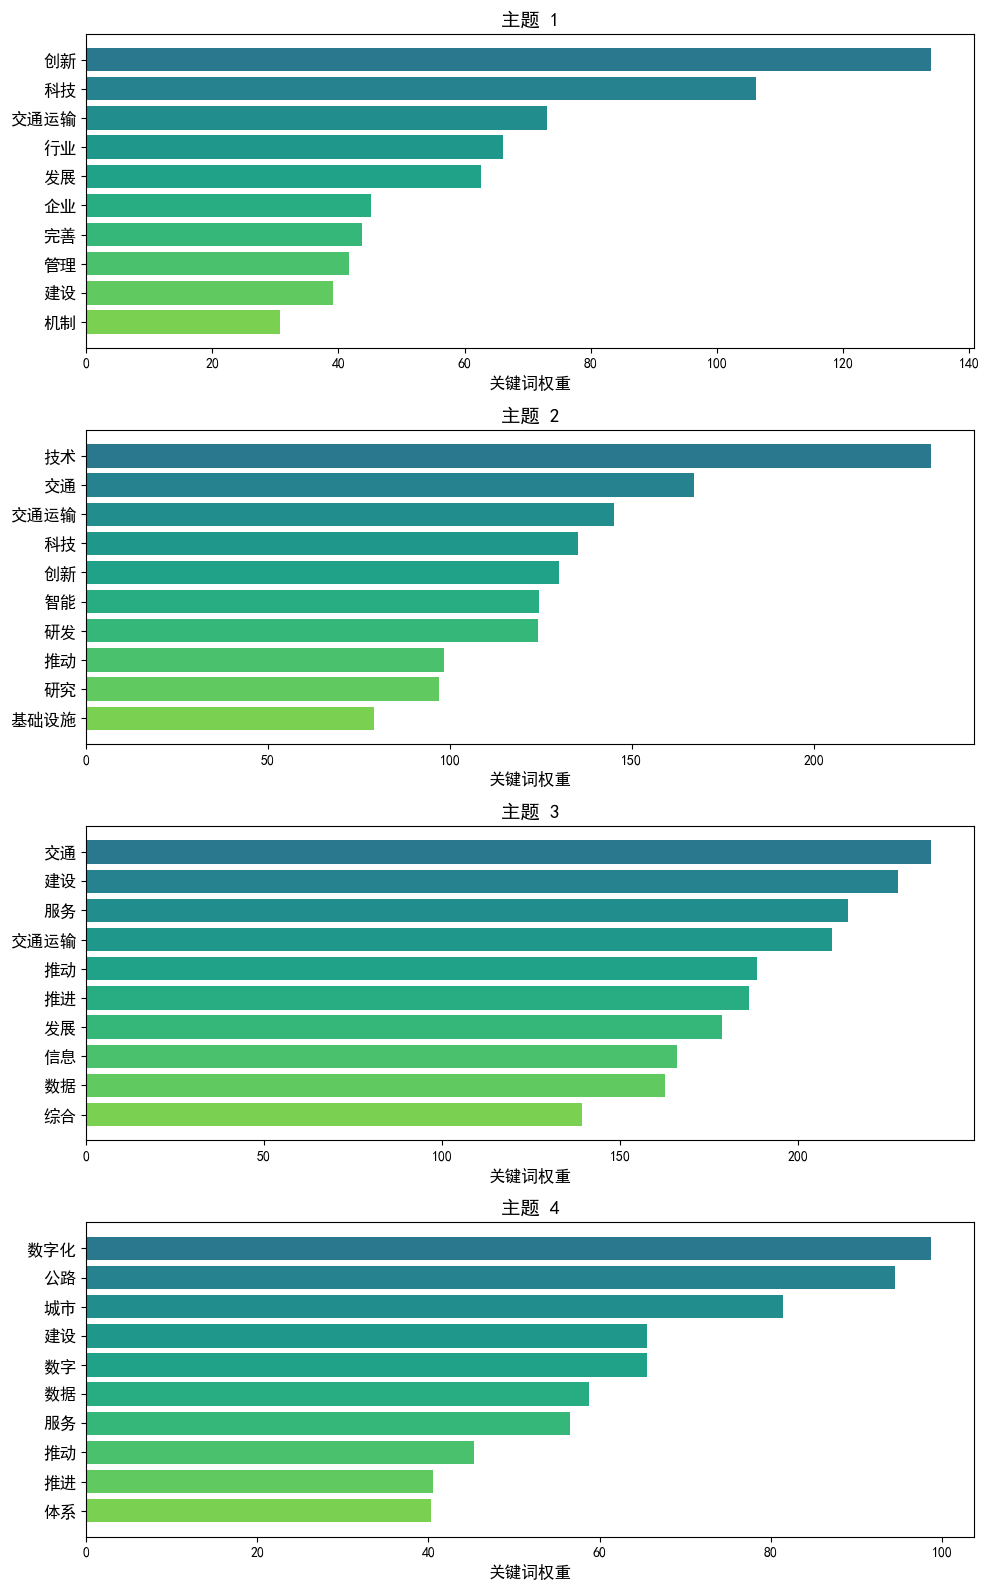

LDA 主题可视化已生成，文件路径： ../result/policy_lda\lda_topics.png


In [3]:
import os
import re
import jieba
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 设置中文字体及允许负号显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 统一结果输出目录
OUTPUT_FOLDER = '../result/policy_lda'
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

def load_policy_texts(folder_path='../data/policy_ch1_bg'):
    """
    加载所有政策文本文件，返回文本列表
    """
    texts = []
    for file in os.listdir(folder_path):
        if file.endswith('.txt'):
            with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
                texts.append(f.read())
    return texts

def load_stopwords(folder_path='../data/texts/stopwords'):
    """
    加载停用词列表，将所有txt文件中的停用词合并为一个集合
    """
    stopwords = set()
    for file in os.listdir(folder_path):
        if file.endswith('.txt'):
            file_path = os.path.join(folder_path, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    sw = line.strip()
                    if sw:
                        stopwords.add(sw)
    return stopwords

def text_cleaning(text, stopwords):
    """
    清洗文本：
      - 去除非中文、英文、数字字符
      - 利用 jieba 进行分词，并过滤停用词
    """
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9]', ' ', text)
    words = jieba.lcut(text)
    filtered_words = [w for w in words if w.strip() and w not in stopwords]
    return filtered_words

def join_tokens(tokens):
    """
    将分词结果用空格连接，适用于 CountVectorizer
    """
    return ' '.join(tokens)

def lda_analysis(policy_texts, stopwords, num_topics=4, num_words=10):
    """
    基于 sklearn 的 LDA 主题建模：
      - policy_texts：文本列表
      - stopwords：停用词集合
      - num_topics：主题数（建议4个主题，对应不同关注点）
      - num_words：每个主题输出的关键词数
    输出主题信息，并返回 LDA 模型、CountVectorizer 对象及文档矩阵
    """
    # 预处理文本：分词后过滤停用词并拼接为字符串
    processed_texts = [join_tokens(text_cleaning(text, stopwords)) for text in policy_texts]
    
    # 构建文档－词语矩阵
    vectorizer = CountVectorizer()
    dt_matrix = vectorizer.fit_transform(processed_texts)
    
    # 训练 LDA 模型
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=10)
    lda.fit(dt_matrix)
    feature_names = vectorizer.get_feature_names_out()
    
    # 输出主题信息
    print("LDA 主题建模结果：")
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-num_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"主题 {topic_idx + 1}: {' '.join(top_features)}")
    
    return lda, vectorizer, dt_matrix

def visualize_lda_topics(lda, vectorizer, num_words=10, output_filename='lda_topics.png'):
    """
    基于 matplotlib 绘制 LDA 每个主题的关键词条形图，
    使用渐变色（采用 viridis）为条形设置颜色，并保存到统一输出目录
    """
    feature_names = vectorizer.get_feature_names_out()
    num_topics = lda.n_components
    # 创建子图，每个主题一个条形图
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, 4 * num_topics))
    if num_topics == 1:
        axes = [axes]
    for idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[:-num_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_values = topic[top_indices]
        
        # 为渐变色取色，按顺序映射数值，颜色从浅到深
        colors = cm.viridis(np.linspace(0.4, 0.8, num_words))
        
        ax = axes[idx]
        ax.barh(range(num_words)[::-1], top_values, color=colors)
        ax.set_yticks(range(num_words)[::-1])
        ax.set_yticklabels(top_words, fontsize=12)
        ax.set_title(f"主题 {idx + 1}", fontsize=14)
        ax.set_xlabel("关键词权重", fontsize=12)
    plt.tight_layout()
    output_path = os.path.join(OUTPUT_FOLDER, output_filename)
    plt.savefig(output_path, dpi=300)
    plt.show()
    print("LDA 主题可视化已生成，文件路径：", output_path)

if __name__ == "__main__":
    # 加载政策文本与停用词
    policy_texts = load_policy_texts()
    stopwords = load_stopwords()
    
    # 执行 LDA 分析
    lda_model, vectorizer, dt_matrix = lda_analysis(policy_texts, stopwords, num_topics=4, num_words=10)
    
    # 生成 LDA 主题条形图可视化
    visualize_lda_topics(lda_model, vectorizer, num_words=10)

In [4]:
# 测试代码
# 全局变量定义
POLICY_TERMS_FILE = '../data/texts/policy_terms.txt'
MODEL_NAME = 'paraphrase-multilingual-MiniLM-L12-v2'
TOOL_DICT = {
    '供给型': ['研发补贴', '人才培养', '基础设施建设', '技术标准', '科研机构'],
    '环境型': ['税收优惠', '法规', '牌照发放', '安全监管', '数据隐私'],
    '需求型': ['政府采购', '场景开放', '示范应用', '市场准入', '消费补贴']
}

import jieba
import jieba.posseg as pseg
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# 加载用户自定义词典
jieba.load_userdict(POLICY_TERMS_FILE)
# 加载预训练语义模型
model = SentenceTransformer(MODEL_NAME)

def enhanced_cut(text):
    """
    对文本进行分词，保留名词、动词以及自定义词性（x），只保留长度 > 1 的词
    """
    words = pseg.cut(text)
    keep_pos = {'n', 'v', 'x'}
    return [word for word, flag in words if flag in keep_pos and len(word) > 1]

def extract_key_phrases(text):
    """
    简单实现：使用 enhanced_cut 结果作为关键短语
    """
    return enhanced_cut(text)

# 将工具类型关键词转换为语义向量（均值作为类型向量）
tool_vectors = {}
for tool_type, keywords in TOOL_DICT.items():
    tool_vectors[tool_type] = model.encode(keywords).mean(axis=0)

def semantic_tool_classification(text, threshold=0.55):
    """
    对输入文本进行语义分析，返回相似度最高且大于阈值的工具类型
    """
    phrases = extract_key_phrases(text)
    if not phrases:
        return None
    phrase_vecs = model.encode(phrases)

    scores = {}
    for tool_type, vec in tool_vectors.items():
        sim = cosine_similarity(phrase_vecs, [vec]).mean()
        scores[tool_type] = sim
    print("相似度分数:", scores)
    max_type = max(scores, key=scores.get)
    return max_type if scores[max_type] > threshold else None

if __name__ == "__main__":
    sample_text = "鼓励企业加大自动驾驶技术研发投入，对通过路测的企业给予税收优惠..."
    result = semantic_tool_classification(sample_text)
    print("语义分类结果:", result)

相似度分数: {'供给型': np.float32(0.5462576), '环境型': np.float32(0.5136819), '需求型': np.float32(0.5922113)}
语义分类结果: 需求型


In [17]:
# --------------------------
# 全局变量定义（优化后）
# --------------------------
FOLDER_PATH = '../data/policy_ch1_bg'
OUTPUT_DIR = "../result/policy_analysis_entropy"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 增强后的政策工具分类体系
POLICY_TOOLS = {
    "供给型": [
        "智能交通设施", "新能源研发", "车路协同试点", "5G基站部署",
        "数据中心建设", "职业技能补贴", "大模型训练平台", "自动驾驶路测区",
        "交通大数据平台", "充电设施建设", "智慧港口升级", "数字航道改造"
    ],
    "环境型": [
        "碳排放标准", "数据安全法", "交通公平性评估", "绿色金融",
        "智能交通法规", "路权分配机制", "环境监测体系", "无障碍出行条例",
        "碳配额管理", "新能源补贴政策", "共享出行规范", "自动驾驶伦理准则"
    ],
    "需求型": [
        "ETC通行优惠", "新能源购置补贴", "智慧停车补贴", "共享汽车试点",
        "出行即服务(MaaS)", "农村客运补贴", "定制公交推广", "适老化出行服务",
        "自动驾驶出租车牌照", "物流补贴", "绿色出行积分", "拥堵收费试点"
    ]
}

# 增强语义扩展映射
SEMANTIC_EXPANSION = {
    "车路协同试点": ["智能道路系统", "协同式自动驾驶"],
    "碳排放标准": ["交通碳足迹管理", "温室气体管控"],
    "适老化出行服务": ["银发交通", "老年友好型交通"],
    "交通公平性评估": ["出行权益保障", "交通资源均衡"],
    "绿色出行积分": ["低碳出行奖励", "碳普惠机制"]
}

# 强化社会意义维度
DOMAIN_KEYWORDS = {
    "科技创新": ["车路协同", "自动驾驶", "大模型", "数字航道"],
    "绿色转型": ["碳排放", "新能源", "绿色金融", "碳配额"],
    "社会公平": ["适老化", "无障碍", "农村客运", "公平性评估"],
    "民生服务": ["智慧停车", "定制公交", "出行即服务", "ETC优惠"]
}

# --------------------------
# 中文字体配置
# --------------------------
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --------------------------
# 其他依赖导入
# --------------------------
import os
import time
import ahocorasick
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict

# ======================
# 核心分析模块（优化版）
# ======================
class EnhancedPolicyEngine:
    def __init__(self):
        self.automaton = ahocorasick.Automaton()
        self.domain_mapping = self._build_domain_mapping()
        self._build_automaton()
        self.replace_table = str.maketrans("", "", " \n\t\r")
    
    def _build_domain_mapping(self):
        mapping = defaultdict(list)
        for domain, keywords in DOMAIN_KEYWORDS.items():
            for kw in keywords:
                mapping[kw].append(domain)
        return mapping
    
    def _build_automaton(self):
        existing_words = set()
        # 多层级构建
        for cat, words in POLICY_TOOLS.items():
            for word in words:
                self._add_word_with_synonyms(word, cat, existing_words)
        
        # 添加语义扩展
        for base_word, synonyms in SEMANTIC_EXPANSION.items():
            original_cat = next(
                (cat for cat, words in POLICY_TOOLS.items() if base_word in words),
                None
            )
            if original_cat:
                for syn in synonyms:
                    self._add_word_with_synonyms(syn, original_cat, existing_words)
        
        self.automaton.make_automaton()
    
    def _add_word_with_synonyms(self, word, cat, existing):
        if word not in existing:
            self.automaton.add_word(word, (cat, word))
            existing.add(word)
    
    def _detect_domain(self, text):
        domain_scores = defaultdict(int)
        for _, (cat, word) in self.automaton.iter(text):
            if word in self.domain_mapping:
                for domain in self.domain_mapping[word]:
                    domain_scores[domain] += 1
        
        # 取前2个主要领域，按得分占比超过15%的领域
        sorted_domains = sorted(domain_scores.items(), key=lambda x: -x[1])
        total = sum(domain_scores.values())
        return [
            domain for domain, score in sorted_domains
            if score / total >= 0.15
        ][:2] if total >0 else ["其他"]
    
    def _time_decay(self, year, policy_type):
        current_year = datetime.now().year
        try:
            target_year = int(year)
            decay_rates = {
                "基础设施建设": 0.92,  # 长期性政策
                "技术标准": 0.85,
                "补贴政策": 0.68,     # 短期性政策
                "法规条例": 0.78
            }
            rate = decay_rates.get(policy_type, 0.8)
            return rate ** (current_year - target_year)
        except:
            return 1.0
    
    def _infer_policy_type(self, categories):
        if "环境型" in categories:
            return "法规条例" if any(w in ["标准","法规"] else "技术标准"
        elif "供给型" in categories:
            return "基础设施建设" if any(w in ["设施","平台"] else "技术标准"
        else:
            return "补贴政策"
    
    def process_file(self, filepath):
        try:
            with open(filepath, "r", encoding="utf-8") as f:
                text = f.read().translate(self.replace_table)
            
            filename = os.path.basename(filepath)
            year = filename.split("_")[0] if "_" in filename else "未知"
            
            # 动态权重配置
            domains = self._detect_domain(text)
            policy_type = self._infer_policy_type(domains)
            time_weight = self._time_decay(year, policy_type)
            
            counts = defaultdict(float)
            for _, (cat, word) in self.automaton.iter(text):
                # 领域相关性加权
                domain_weight = 1.2 if any(d in domains for d in DOMAIN_KEYWORDS.keys()) else 1.0
                counts[cat] += (domain_weight * time_weight)
            
            return {
                "filename": filename,
                "year": year,
                "domain": "/".join(domains),
                "policy_type": policy_type,
                "供给型": counts.get("供给型", 0.0),
                "环境型": counts.get("环境型", 0.0),
                "需求型": counts.get("需求型", 0.0),
                "social_impact": 1.2 if "社会公平" in domains else 1.0,
                "total": sum(counts.values())
            }
        except Exception as e:
            print(f"文件处理失败: {filepath}\n错误: {str(e)}")
            return None

# ======================
# 增强型分析模块
# ======================
def enhanced_analysis(df):
    """多维分析框架"""
    # 政策工具熵值计算
    entropy, probs = calculate_entropy(df)
    
    # 社会影响指数计算
    social_index = df[df['social_impact'] > 1]['social_impact'].mean()
    
    # 生成增强报告
    report = []
    report.append("="*40)
    report.append("增强型政策分析报告")
    report.append(f"生成时间: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
    report.append(f"有效政策文件: {len(df)} 份")
    report.append("\n核心发现：")
    report.append(f"1. 政策工具多样性指数: {entropy:.2f}（0-1越高越均衡）")
    report.append(f"2. 社会公平相关政策占比: {len(df[df['domain'].str.contains('社会公平')])/len(df):.1%}")
    report.append(f"3. 科技创新政策持续度: {df[df['domain'].str.contains('科技创新')]['year'].nunique()} 年")
    
    # 可视化增强
    plt.figure(figsize=(12,6))
    ax1 = df.groupby('year')['social_impact'].mean().plot(
        color='#e74c3c', marker='o', label='社会影响指数'
    )
    ax2 = df.groupby('year')['total'].mean().plot(
        secondary_y=True, color='#3498db', marker='s', label='政策强度'
    )
    plt.title("政策强度与社会影响趋势双轴分析")
    ax1.set_ylabel("社会影响指数")
    ax2.set_ylabel("政策强度")
    plt.savefig(os.path.join(OUTPUT_DIR, "enhanced_trend.png"))
    plt.close()
    
    return '\n'.join(report)

# ======================
# 主程序入口（优化版）
# ======================
if __name__ == "__main__":
    start_time = time.time()
    engine = EnhancedPolicyEngine()
    
    file_list = [
        os.path.join(FOLDER_PATH, f)
        for f in os.listdir(FOLDER_PATH)
        if f.endswith(".txt") and os.path.isfile(os.path.join(FOLDER_PATH, f))
    ]
    
    results = []
    for file in file_list:
        res = engine.process_file(file)
        if res:
            results.append(res)
    
    df = pd.DataFrame(results)
    report = enhanced_analysis(df)
    
    # 保存结构化结果
    df.to_excel(os.path.join(OUTPUT_DIR, "enhanced_analysis.xlsx"), index=False)
    with open(os.path.join(OUTPUT_DIR, "enhanced_report.txt"), "w") as f:
        f.write(report)
    
    print(f"分析完成！耗时: {time.time()-start_time:.2f}秒")
    print("增强分析结果已保存至:", os.path.abspath(OUTPUT_DIR))

SyntaxError: expected 'else' after 'if' expression (2671049450.py, line 135)

In [7]:
# --------------------------
# 全局变量定义
# --------------------------
POLICY_ANALYSIS_CSV = '../result/policy_analyse_visiable/policy_analysis_results.csv'
TOPIC_ANALYSIS_CSV = '../result/policy_analyse_visiable/topic_analysis_results.csv'
OUTPUT_DIR = '../result/policy_analyse_visiable/figures'  # 输出图像保存文件夹
FIG_DPI = 300

import os
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 配置图形显示参数
# --------------------------
plt.rcParams['figure.dpi'] = FIG_DPI
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# --------------------------
# 确保输出文件夹存在
# --------------------------
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# --------------------------
# 加载数据
# --------------------------
policy_analysis_df = pd.read_csv(POLICY_ANALYSIS_CSV)
topic_analysis_df = pd.read_csv(TOPIC_ANALYSIS_CSV)

# --------------------------
# 1. 政策工具类型与科技创新关联（饼图）
# --------------------------
def plot_policy_tool_pie(df, save_path):
    counts = df['分类结果'].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.title('不同政策工具类型分布（可能对科技创新的影响）')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    print("饼图已保存至", save_path)

# --------------------------
# 2. 政策主题与社会变革关联（柱状图）
# --------------------------
def plot_topic_bar(df, save_path):
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, x='主题编号', y=df.index, hue='映射工具类型', orient='h')
    plt.title('政策主题与映射工具类型关系（对社会变革的潜在影响）')
    plt.xlabel('主题编号')
    plt.ylabel('映射工具类型')
    plt.legend(title='映射工具类型', loc='lower right')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    print("柱状图已保存至", save_path)

# --------------------------
# 3. 政策趋势与变革趋势（折线图）
# --------------------------
def plot_trend_line(df, save_path):
    df['文件编号'] = df['文件'].str.extract('(\d+)').astype(int)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='文件编号', y='分类结果', marker='o')
    plt.title('政策工具类型随文件编号的变化趋势（科技创新和社会变革政策导向演变）')
    plt.xlabel('文件编号')
    plt.xticks(rotation=45)
    plt.ylabel('分类结果')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    print("折线图已保存至", save_path)

# --------------------------
# 4. 关联矩阵展示（热力图）
# --------------------------
def plot_crosstab_heatmap(policy_df, topic_df, save_path):
    merged_df = pd.merge(policy_df, topic_df, left_on='分类结果', right_on='映射工具类型', how='left')
    cross_tab = pd.crosstab(merged_df['主题编号'], merged_df['分类结果'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('政策主题与政策工具类型关联矩阵（对科技创新和社会变革的综合影响）')
    plt.xlabel('文件分类结果')
    plt.xticks(rotation=45)
    plt.ylabel('主题编号')
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    print("热力图已保存至", save_path)

# --------------------------
# 主程序入口
# --------------------------
if __name__ == "__main__":
    pie_path = os.path.join(OUTPUT_DIR, "policy_tool_pie.png")
    bar_path = os.path.join(OUTPUT_DIR, "topic_bar.png")
    trend_path = os.path.join(OUTPUT_DIR, "trend_line.png")
    heatmap_path = os.path.join(OUTPUT_DIR, "crosstab_heatmap.png")
    
    print("绘制饼图...")
    plot_policy_tool_pie(policy_analysis_df, pie_path)
    
    print("绘制柱状图...")
    plot_topic_bar(topic_analysis_df, bar_path)
    
    print("绘制折线图...")
    plot_trend_line(policy_analysis_df, trend_path)
    
    print("绘制热力图...")
    plot_crosstab_heatmap(policy_analysis_df, topic_analysis_df, heatmap_path)

<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
C:\Users\12914\AppData\Local\Temp\ipykernel_20936\1865520464.py:65: SyntaxWarning: invalid escape sequence '\d'
  df['文件编号'] = df['文件'].str.extract('(\d+)').astype(int)


绘制饼图...
饼图已保存至 ../result/policy_analyse_visiable/figures\policy_tool_pie.png
绘制柱状图...
柱状图已保存至 ../result/policy_analyse_visiable/figures\topic_bar.png
绘制折线图...
折线图已保存至 ../result/policy_analyse_visiable/figures\trend_line.png
绘制热力图...
热力图已保存至 ../result/policy_analyse_visiable/figures\crosstab_heatmap.png


#### 进行三个维度的分析
##### 首先分析政策熵值，进行计算

In [22]:
# --------------------------
# 全局变量定义（优化后）
# --------------------------
FOLDER_PATH = '../data/policy_ch1_bg'
OUTPUT_DIR = "../result/policy_analysis_entropy"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 增强后的政策工具分类体系
POLICY_TOOLS = {
    "供给型": [
        "智能交通设施", "新能源研发", "车路协同试点", "5G基站部署",
        "数据中心建设", "职业技能补贴", "大模型训练平台", "自动驾驶路测区",
        "交通大数据平台", "充电设施建设", "智慧港口升级", "数字航道改造"
    ],
    "环境型": [
        "碳排放标准", "数据安全法", "交通公平性评估", "绿色金融",
        "智能交通法规", "路权分配机制", "环境监测体系", "无障碍出行条例",
        "碳配额管理", "新能源补贴政策", "共享出行规范", "自动驾驶伦理准则"
    ],
    "需求型": [
        "ETC通行优惠", "新能源购置补贴", "智慧停车补贴", "共享汽车试点",
        "出行即服务(MaaS)", "农村客运补贴", "定制公交推广", "适老化出行服务",
        "自动驾驶出租车牌照", "物流补贴", "绿色出行积分", "拥堵收费试点"
    ]
}

# 增强语义扩展映射
SEMANTIC_EXPANSION = {
    "车路协同试点": ["智能道路系统", "协同式自动驾驶"],
    "碳排放标准": ["交通碳足迹管理", "温室气体管控"],
    "适老化出行服务": ["银发交通", "老年友好型交通"],
    "交通公平性评估": ["出行权益保障", "交通资源均衡"],
    "绿色出行积分": ["低碳出行奖励", "碳普惠机制"]
}

# 强化社会意义维度
DOMAIN_KEYWORDS = {
    "科技创新": ["车路协同", "自动驾驶", "大模型", "数字航道"],
    "绿色转型": ["碳排放", "新能源", "绿色金融", "碳配额"],
    "社会公平": ["适老化", "无障碍", "农村客运", "公平性评估"],
    "民生服务": ["智慧停车", "定制公交", "出行即服务", "ETC优惠"]
}

# --------------------------
# 中文字体配置
# --------------------------
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --------------------------
# 其他依赖导入
# --------------------------
import os
import time
import ahocorasick
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict

# ======================
# 核心分析模块（优化版）
# ======================
class EnhancedPolicyEngine:
    def __init__(self):
        self.automaton = ahocorasick.Automaton()
        self.domain_mapping = self._build_domain_mapping()
        self._build_automaton()
        self.replace_table = str.maketrans("", "", " \n\t\r")
    
    def _build_domain_mapping(self):
        mapping = defaultdict(list)
        for domain, keywords in DOMAIN_KEYWORDS.items():
            for kw in keywords:
                mapping[kw].append(domain)
        return mapping
    
    def _build_automaton(self):
        existing_words = set()
        # 多层级构建
        for cat, words in POLICY_TOOLS.items():
            for word in words:
                self._add_word_with_synonyms(word, cat, existing_words)
        
        # 添加语义扩展
        for base_word, synonyms in SEMANTIC_EXPANSION.items():
            original_cat = next(
                (cat for cat, words in POLICY_TOOLS.items() if base_word in words),
                None
            )
            if original_cat:
                for syn in synonyms:
                    self._add_word_with_synonyms(syn, original_cat, existing_words)
        
        self.automaton.make_automaton()
    
    def _add_word_with_synonyms(self, word, cat, existing):
        if word not in existing:
            self.automaton.add_word(word, (cat, word))
            existing.add(word)
    
    def _detect_domain(self, text):
        domain_scores = defaultdict(int)
        for _, (cat, word) in self.automaton.iter(text):
            if word in self.domain_mapping:
                for domain in self.domain_mapping[word]:
                    domain_scores[domain] += 1
        
        # 取前2个主要领域，按得分占比超过15%的领域
        sorted_domains = sorted(domain_scores.items(), key=lambda x: -x[1])
        total = sum(domain_scores.values())
        return [
            domain for domain, score in sorted_domains
            if score / total >= 0.15
        ][:2] if total >0 else ["其他"]
    
    def _time_decay(self, year, policy_type):
        current_year = datetime.now().year
        try:
            target_year = int(year)
            decay_rates = {
                "基础设施建设": 0.92,  # 长期性政策
                "技术标准": 0.85,
                "补贴政策": 0.68,     # 短期性政策
                "法规条例": 0.78
            }
            rate = decay_rates.get(policy_type, 0.8)
            return rate ** (current_year - target_year)
        except:
            return 1.0
    
    def _infer_policy_type(self, categories):
        if "环境型" in categories:
            return "法规条例" if any(w in categories for w in ["标准", "法规"]) else "技术标准"
        elif "供给型" in categories:
            return "基础设施建设" if any(w in categories for w in ["设施", "平台"]) else "技术标准"
        else:
            return "补贴政策"
    
    def process_file(self, filepath):
        try:
            with open(filepath, "r", encoding="utf-8") as f:
                text = f.read().translate(self.replace_table)
            
            filename = os.path.basename(filepath)
            year = filename.split("_")[0] if "_" in filename else "未知"
            
            # 动态权重配置
            domains = self._detect_domain(text)
            policy_type = self._infer_policy_type(domains)
            time_weight = self._time_decay(year, policy_type)
            
            counts = defaultdict(float)
            for _, (cat, word) in self.automaton.iter(text):
                # 领域相关性加权
                domain_weight = 1.2 if any(d in domains for d in DOMAIN_KEYWORDS.keys()) else 1.0
                counts[cat] += (domain_weight * time_weight)
            
            return {
                "filename": filename,
                "year": year,
                "domain": "/".join(domains),
                "policy_type": policy_type,
                "供给型": counts.get("供给型", 0.0),
                "环境型": counts.get("环境型", 0.0),
                "需求型": counts.get("需求型", 0.0),
                "social_impact": 1.2 if "社会公平" in domains else 1.0,
                "total": sum(counts.values())
            }
        except Exception as e:
            print(f"文件处理失败: {filepath}\n错误: {str(e)}")
            return None

# ======================
# 增强型分析模块
# ======================
def enhanced_analysis(df):
    """多维分析框架"""
    # 政策工具熵值计算
    entropy, probs = calculate_entropy(df)
    
    # 社会影响指数计算
    social_index = df[df['social_impact'] > 1]['social_impact'].mean()
    
    # 生成增强报告
    report = []
    report.append("="*40)
    report.append("增强型政策分析报告")
    report.append(f"生成时间: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
    report.append(f"有效政策文件: {len(df)} 份")
    report.append("\n核心发现：")
    report.append(f"1. 政策工具多样性指数: {entropy:.2f}（0-1越高越均衡）")
    report.append(f"2. 社会公平相关政策占比: {len(df[df['domain'].str.contains('社会公平')])/len(df):.1%}")
    report.append(f"3. 科技创新政策持续度: {df[df['domain'].str.contains('科技创新')]['year'].nunique()} 年")
    
    # 可视化增强
    plt.figure(figsize=(12,6))
    ax1 = df.groupby('year')['social_impact'].mean().plot(
        color='#e74c3c', marker='o', label='社会影响指数'
    )
    ax2 = df.groupby('year')['total'].mean().plot(
        secondary_y=True, color='#3498db', marker='s', label='政策强度'
    )
    plt.title("政策强度与社会影响趋势双轴分析")
    ax1.set_ylabel("社会影响指数")
    ax2.set_ylabel("政策强度")
    plt.savefig(os.path.join(OUTPUT_DIR, "enhanced_trend.png"))
    plt.close()
    
    return '\n'.join(report)

# ======================
# 主程序入口（优化版）
# ======================
if __name__ == "__main__":
    start_time = time.time()
    engine = EnhancedPolicyEngine()
    
    file_list = [
        os.path.join(FOLDER_PATH, f)
        for f in os.listdir(FOLDER_PATH)
        if f.endswith(".txt") and os.path.isfile(os.path.join(FOLDER_PATH, f))
    ]
    
    results = []
    for file in file_list:
        res = engine.process_file(file)
        if res:
            results.append(res)
    
    df = pd.DataFrame(results)
    report = enhanced_analysis(df)
    
    # 保存结构化结果
    df.to_excel(os.path.join(OUTPUT_DIR, "enhanced_analysis.xlsx"), index=False)
    with open(os.path.join(OUTPUT_DIR, "enhanced_report.txt"), "w") as f:
        f.write(report)
    
    print(f"分析完成！耗时: {time.time()-start_time:.2f}秒")
    print("增强分析结果已保存至:", os.path.abspath(OUTPUT_DIR))

分析完成！耗时: 0.20秒
增强分析结果已保存至: d:\CODE_WORLD\No.15CDR_workspace\result\policy_analysis_entropy


In [ ]:
# 微博爬取数据合并
import os
import pandas as pd

# 指定存放 CSV 文件的文件夹路径
CSV_FOLDER = r"D:\CODE_WORLD\project_donwload_from_github\weibo-search\结果文件"  # 请修改为实际的文件夹路径
# 输出的 TXT 文件路径（当前目录下）
OUTPUT_TXT = CSV_FOLDER

with open(OUTPUT_TXT, "w", encoding="utf-8") as fout:
    # 遍历文件夹中的所有 CSV 文件
    for filename in os.listdir(CSV_FOLDER):
        if filename.endswith(".csv"):
            file_path = os.path.join(CSV_FOLDER, filename)
            # 读取 CSV 文件（编码根据实际情况进行调整，如 utf-8 或 gbk）
            try:
                df = pd.read_csv(file_path, encoding="utf-8")
            except Exception as e:
                print(f"读取 {filename} 时出错，尝试采用 gbk 编码")
                df = pd.read_csv(file_path, encoding="gbk")
                
            # 检查是否存在“微博正文”列
            if "微博正文" in df.columns:
                # 过滤空值，并写入 TXT 文件
                for text in df["微博正文"].dropna():
                    fout.write(str(text).strip() + "\n")
            else:
                print(f"文件 {filename} 中未找到 '微博正文' 列")
                
print(f"已将所有微博正文保存到 {OUTPUT_TXT}")

已将所有微博正文保存到 weibo_comments.txt


待改进：
1.统一存储所有结果的目录
2.政策文本的丰富，丰富以后再跑一边


结合了跨文本类型对比分析、混合主题模型和增强可视化技术

In [26]:
import os
# --------------------------
# 全局变量定义
# --------------------------
CUSTOM_DICT = "../data/texts/policy_terms.txt"
STOPWORDS_PATH = "../data/texts/stopwords/hit_stopwords.txt"
WEIBO_FILE = "../data/texts/weibo_content.txt"   # 微博文本输入文件（单个txt文件，每行一条微博）
OUTPUT_DIR = "../result/advanced_topic_analysis"   # 结果输出文件夹
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 自定义的停用词列表（随时修改添加）
CUSTOM_ADDITIONAL_STOPWORDS = {
    "的", "了", "在", "和", "是", "我", "也", "就", "都", "而", "但", "与","视频","车主","芝能"
}

# --------------------------
# 依赖包导入及配置
# --------------------------
import numpy as np
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import pairwise_distances
import matplotlib
import seaborn as sns

# 指定中文字体以及允许负号显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set(font="SimHei", style="whitegrid", font_scale=1.2)

# --------------------------
# 核心类定义
# --------------------------
class AdvancedTopicAnalyzer:
    def __init__(self, text_type='weibo'):
        self.text_type = text_type
        self.custom_dict = CUSTOM_DICT
        # 加载文件停用词并与自定义停用词合并
        file_stopwords = self.load_stopwords(STOPWORDS_PATH)
        self.stopwords = list(file_stopwords.union(CUSTOM_ADDITIONAL_STOPWORDS))
        
        # 微博使用5个主题，否则使用6个主题
        self.topic_num = 5 if text_type == 'weibo' else 6
        self.top_words_num = 8

        # 初始化分词器，加载自定义词典
        jieba.load_userdict(self.custom_dict)
        self.vectorizer = TfidfVectorizer(max_features=1000,
                                          tokenizer=self.tokenize,
                                          stop_words=self.stopwords)

    def load_stopwords(self, path):
        with open(path, 'r', encoding='utf-8') as f:
            return set(line.strip() for line in f if line.strip())

    def tokenize(self, text):
        import jieba.posseg as pseg
        words = []
        for w, flag in pseg.cut(text):
            if flag.startswith('n') and len(w) > 1:
                if w not in self.stopwords:
                    words.append(w)
        return words

    def load_data(self, path):
        """
        如果 path 为文件，则认为所有微博内容在同一个txt文件中，按行分割为多个文档；
        如果 path 为目录，则遍历目录读取所有文件。
        """
        docs = []
        if os.path.isfile(path):
            with open(path, 'r', encoding='utf-8') as f:
                content = f.read()
            docs = [line.strip() for line in content.splitlines() if line.strip()]
        elif os.path.isdir(path):
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='utf-8') as f:
                        docs.append(f.read())
        return docs

    def train_models(self, docs):
        dtm = self.vectorizer.fit_transform(docs)
        nmf = NMF(n_components=self.topic_num, init='nndsvda', random_state=42)
        nmf.fit(dtm)
        lda = LatentDirichletAllocation(n_components=self.topic_num,
                                        learning_method='online',
                                        random_state=42)
        lda.fit(dtm)
        return dtm, nmf, lda

    def get_hybrid_topics(self, model, feature_names):
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            top_features = [feature_names[i]
                            for i in topic.argsort()[:-self.top_words_num-1:-1]]
            topics.append(top_features)
        return topics

    def visualize_contrast(self, nmf_topics, lda_topics):
        plt.figure(figsize=(15, 8))
        # NMF词云
        plt.subplot(1, 2, 1)
        text_nmf = ' '.join([' '.join(t) for t in nmf_topics])
        wordcloud_nmf = WordCloud(font_path='simhei.ttf', background_color='white').generate(text_nmf)
        plt.imshow(wordcloud_nmf, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"NMF Topics - {self.text_type}")

        # LDA词云
        plt.subplot(1, 2, 2)
        text_lda = ' '.join([' '.join(t) for t in lda_topics])
        wordcloud_lda = WordCloud(font_path='simhei.ttf', background_color='white').generate(text_lda)
        plt.imshow(wordcloud_lda, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"LDA Topics - {self.text_type}")
        
        plt.tight_layout()
        save_path = os.path.join(OUTPUT_DIR, f"{self.text_type}_contrast.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"对比词云已保存至 {save_path}")

    def semantic_space_analysis(self, dtm, lda_model):
        """
        使用 TSNE 对文档进行二维投影，
        根据 LDA 模型计算每个文档的主要主题，
        用颜色区分不同主题，并添加部分文本标注以及颜色图例。
        """
        from sklearn.manifold import TSNE
        import numpy as np
        from matplotlib.lines import Line2D

        # 使用 TSNE 投影，避免 PCA 初始化问题
        tsne = TSNE(n_components=2, random_state=42, perplexity=20, init="random")
        projections = tsne.fit_transform(dtm.toarray())

        # 通过 LDA 得到文档主题分布，并取最大值对应的主题作为主要主题
        topic_distributions = lda_model.transform(dtm)
        dominant_topics = np.argmax(topic_distributions, axis=1)
        num_topics = np.max(dominant_topics) + 1

        # 定义颜色映射（例如使用 tab10 调色板）
        cmap = plt.get_cmap("tab10", num_topics)
        colors = [cmap(label) for label in dominant_topics]

        plt.figure(figsize=(12, 9))
        scatter = plt.scatter(projections[:, 0], projections[:, 1],
                              c=colors, alpha=0.6, edgecolors='k', s=80)

        # 添加颜色图例
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"主题 {i+1}",
                                  markerfacecolor=cmap(i), markersize=10, markeredgecolor='k')
                           for i in range(num_topics)]
        plt.legend(handles=legend_elements, loc="best", title="主要主题")

        # 可选：为部分文档添加文本标注（如前10个文档）
        for idx, (x, y) in enumerate(projections[:10]):
            plt.text(x, y, f"Doc{idx+1}", fontsize=9)

        plt.title(f"语义空间投影（颜色区分主要主题） - {self.text_type}", fontsize=16)
        save_path = os.path.join(OUTPUT_DIR, f"{self.text_type}_semantic_with_topics.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"带颜色图例和文本标注的语义空间投影图已保存至 {save_path}")

    def output_statistics(self, docs, dtm, nmf, lda):
        """
        输出一些统计检验数据以供分析和报告撰写：
          - 文档数量、词汇量
          - 平均文档长度（分词后词数的均值和标准差）
          - 文档主导主题概率的均值和标准差（来自 LDA 主题分布）
        """
        num_docs = len(docs)
        vocab_size = len(self.vectorizer.get_feature_names_out())
        token_counts = [len(self.tokenize(doc)) for doc in docs]
        avg_length = np.mean(token_counts)
        std_length = np.std(token_counts)
        
        # 对每个文档，计算 LDA 得到的主题概率最大值
        topic_distributions = lda.transform(dtm)
        dominant_probs = np.max(topic_distributions, axis=1)
        avg_dominant = np.mean(dominant_probs)
        std_dominant = np.std(dominant_probs)
        
        stats_report = (
            "==== 统计检验数据 ====\n"
            f"文档数量: {num_docs}\n"
            f"词汇量: {vocab_size}\n"
            f"平均文档长度（词数）: {avg_length:.2f} ± {std_length:.2f}\n"
            f"平均主导主题概率: {avg_dominant:.2f} ± {std_dominant:.2f}\n"
        )
        print(stats_report)
        
        # 将统计数据写入报告文件
        stats_filepath = os.path.join(OUTPUT_DIR, "statistics_report.txt")
        with open(stats_filepath, "w", encoding="utf-8") as fout:
            fout.write(stats_report)
        print(f"统计检验报告已保存至 {stats_filepath}")

if __name__ == "__main__":
    # 微博分析：内容在单个txt文件 WEIBO_FILE 中
    weibo_analyzer = AdvancedTopicAnalyzer(text_type='weibo')
    weibo_docs = weibo_analyzer.load_data(WEIBO_FILE)
    dtm, nmf, lda = weibo_analyzer.train_models(weibo_docs)
    
    feature_names = weibo_analyzer.vectorizer.get_feature_names_out()
    weibo_nmf_topics = weibo_analyzer.get_hybrid_topics(nmf, feature_names)
    weibo_lda_topics = weibo_analyzer.get_hybrid_topics(lda, feature_names)
    
    # 输出主题关键词便于检查
    print("NMF Topics:")
    for idx, topic in enumerate(weibo_nmf_topics):
        print(f"Topic {idx+1}: {', '.join(topic)}")
    
    print("\nLDA Topics:")
    for idx, topic in enumerate(weibo_lda_topics):
        print(f"Topic {idx+1}: {', '.join(topic)}")
    
    weibo_analyzer.visualize_contrast(weibo_nmf_topics, weibo_lda_topics)
    weibo_analyzer.semantic_space_analysis(dtm, lda)
    
    # 输出统计检验数据
    weibo_analyzer.output_statistics(weibo_docs, dtm, nmf, lda)

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF Topics:
Topic 1: 新能源, 汽车, 中国, 汽场, 小米, 比亚迪, 销量, 市场
Topic 2: 理想, 汽车, 充电站, 小米, 上线, 速度, 城市, 销量
Topic 3: 小鹏, 智驾, 价格, 小米, 全系, 何小鹏, 图灵, 续航
Topic 4: 电车, 服务区, 电池, 续航, 换电, 电站, 乐道, 排队
Topic 5: 特斯拉, 中国, 美国, 充电站, 占用费, 关税, 全球, 品牌

LDA Topics:
Topic 1: 小鹏, 特斯拉, 小米, 汽车, 新能源, 美国, 销量, 中国
Topic 2: 理想, 服务区, 车位, 充电站, 汽车, 小区, 领克, 电动车
Topic 3: 新能源, 中国, 汽车, 市场, 智能, 华为, 技术, 科技
Topic 4: 新能源, 汽场, 汽车, 功率, 新知, 比亚迪, 国网, 日报
Topic 5: 电车, 乐道, 续航, 换电, 电池, 新能源, 电站, 增程
对比词云已保存至 ../result/advanced_topic_analysis\weibo_contrast.png
带颜色图例和文本标注的语义空间投影图已保存至 ../result/advanced_topic_analysis\weibo_semantic_with_topics.png
==== 统计检验数据 ====
文档数量: 8890
词汇量: 1000
平均文档长度（词数）: 27.74 ± 40.02
平均主导主题概率: 0.59 ± 0.14

统计检验报告已保存至 ../result/advanced_topic_analysis\statistics_report.txt


In [12]:
# --------------------------
# 全局变量定义
# --------------------------
CUSTOM_DICT = "../data/texts/policy_terms.txt"
STOPWORDS_PATH = "../data/texts/stopwords/hit_stopwords.txt"
POLICY_FOLDER = "../data/policy_ch1_bg"  # 政策文本输入文件夹
OUTPUT_DIR = "../result/LDA"             # 结果输出文件夹
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------
# 依赖包导入及配置
# --------------------------
import os
import numpy as np
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib

# 指定中文字体以及允许负号显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set(style="whitegrid", font_scale=1.2)

# --------------------------
# 核心类定义
# --------------------------
class AdvancedTopicAnalyzer:
    def __init__(self, text_type='weibo'):
        self.text_type = text_type
        self.custom_dict = CUSTOM_DICT
        self.stopwords = list(self.load_stopwords(STOPWORDS_PATH))
        # 微博使用5个主题，否则使用6个主题
        self.topic_num = 5 if text_type == 'weibo' else 6
        self.top_words_num = 8

        # 设置结果输出目录（这里统一使用全局 OUTPUT_DIR）
        self.result_dir = OUTPUT_DIR
        
        # 初始化分词器，加载自定义词典
        jieba.load_userdict(self.custom_dict)
        self.vectorizer = TfidfVectorizer(max_features=1000,
                                          tokenizer=self.tokenize,
                                          stop_words=self.stopwords)

    def load_stopwords(self, path):
        with open(path, 'r', encoding='utf-8') as f:
            return set(line.strip() for line in f if line.strip())

    def tokenize(self, text):
        import jieba.posseg as pseg
        # 仅保留长度大于1的名词，过滤停用词
        words = []
        for w, flag in pseg.cut(text):
            if flag.startswith('n') and len(w) > 1:
                if w not in self.stopwords:
                    words.append(w)
        return words

    def load_data(self, folder_path):
        # 遍历输入文件夹中的所有文件，读取文本内容
        docs = []
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                with open(file_path, 'r', encoding='utf-8') as f:
                    docs.append(f.read())
        return docs

    def train_models(self, docs):
        dtm = self.vectorizer.fit_transform(docs)

        nmf = NMF(n_components=self.topic_num, init='nndsvda', random_state=42)
        nmf.fit(dtm)

        lda = LatentDirichletAllocation(n_components=self.topic_num,
                                        learning_method='online',
                                        random_state=42)
        lda.fit(dtm)

        return dtm, nmf, lda

    def get_hybrid_topics(self, model, feature_names):
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            top_features = [feature_names[i]
                            for i in topic.argsort()[:-self.top_words_num-1:-1]]
            topics.append(top_features)
        return topics

    def visualize_contrast(self, nmf_topics, lda_topics):
        # 双模型词云对比 —— 使用 WordCloud 展示NMF与LDA模型提取的关键词
        plt.figure(figsize=(15, 8))
        # NMF词云
        plt.subplot(1, 2, 1)
        text_nmf = ' '.join([' '.join(t) for t in nmf_topics])
        wordcloud_nmf = WordCloud(font_path='simhei.ttf',
                                  background_color='white',
                                  width=600, height=400).generate(text_nmf)
        plt.imshow(wordcloud_nmf, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"NMF Topics - {self.text_type}", fontsize=16)
        # LDA词云
        plt.subplot(1, 2, 2)
        text_lda = ' '.join([' '.join(t) for t in lda_topics])
        wordcloud_lda = WordCloud(font_path='simhei.ttf',
                                  background_color='white',
                                  width=600, height=400).generate(text_lda)
        plt.imshow(wordcloud_lda, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"LDA Topics - {self.text_type}", fontsize=16)

        plt.tight_layout()
        save_path = os.path.join(self.result_dir, f"{self.text_type}_contrast.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"对比词云已保存至 {save_path}")

    def semantic_space_analysis(self, dtm):
        n_samples = dtm.shape[0]
        # 确保 perplexity 小于样本数，至少为1
        perplexity = 20 if n_samples > 20 else max(1, n_samples - 1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        projections = tsne.fit_transform(dtm.toarray())
        plt.figure(figsize=(10, 8))
        plt.scatter(projections[:, 0], projections[:, 1],
                    alpha=0.6, edgecolors='k')
        plt.title(f"Semantic Space Projection - {self.text_type}", fontsize=16)
        plt.xlabel("Component 1", fontsize=14)
        plt.ylabel("Component 2", fontsize=14)
        plt.grid(True)
        plt.tight_layout()
        save_path = os.path.join(self.result_dir, f"{self.text_type}_semantic.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()

    def cross_domain_analysis(self, nmf_topics, lda_topics):
        # 跨模型主题相似度热力图，显示不同模型间主题的余弦距离
        all_topics = nmf_topics + lda_topics
        topic_vectors = [self.vectorizer.transform([' '.join(t)]) for t in all_topics]

        similarity_matrix = pairwise_distances(
            np.vstack([v.toarray() for v in topic_vectors]),
            metric='cosine'
        )

        plt.figure(figsize=(12, 10))
        ax = sns.heatmap(similarity_matrix, annot=True, cmap='viridis',
                         xticklabels=[str(i+1) for i in range(len(all_topics))],
                         yticklabels=[str(i+1) for i in range(len(all_topics))],
                         fmt=".2f", linewidths=.5)
        plt.title("Cross-Model Topic Similarity", fontsize=16)
        plt.tight_layout()
        save_path = os.path.join(self.result_dir, "cross_similarity.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"跨模型相似度矩阵图已保存至 {save_path}")

    def visualize_topic_word_distribution(self, model, feature_names, model_name="Model"):
        # 分别生成每个主题中高权重词的条形图，直观展示主题关键词分布
        for topic_idx, topic in enumerate(model.components_):
            top_indices = topic.argsort()[:-self.top_words_num-1:-1]
            top_weights = topic[top_indices]
            top_terms = [feature_names[i] for i in top_indices]

            plt.figure(figsize=(8, 4))
            sns.barplot(x=top_weights, y=top_terms, palette="viridis")
            plt.title(f"{model_name} - Topic {topic_idx+1}", fontsize=16)
            plt.xlabel("Weight", fontsize=14)
            plt.ylabel("Term", fontsize=14)
            plt.tight_layout()
            save_path = os.path.join(self.result_dir, f"{self.text_type}_{model_name}_topic_{topic_idx+1}.png")
            plt.savefig(save_path, dpi=300)
            plt.close()

if __name__ == "__main__":
    # 政策分析示例：输入文件夹使用全局变量 POLICY_FOLDER
    analyzer = AdvancedTopicAnalyzer(text_type='policy')
    docs = analyzer.load_data(POLICY_FOLDER)
    dtm, nmf, lda = analyzer.train_models(docs)

    feature_names = analyzer.vectorizer.get_feature_names_out()
    nmf_topics = analyzer.get_hybrid_topics(nmf, feature_names)
    lda_topics = analyzer.get_hybrid_topics(lda, feature_names)

    # 输出主题关键词便于检查
    print("NMF Topics:")
    for idx, topic in enumerate(nmf_topics):
        print(f"Topic {idx+1}: {', '.join(topic)}")

    print("\nLDA Topics:")
    for idx, topic in enumerate(lda_topics):
        print(f"Topic {idx+1}: {', '.join(topic)}")

    # 可视化对比词云与语义空间投影，跨模型相似度热力图，以及各主题词权重分布
    analyzer.visualize_contrast(nmf_topics, lda_topics)
    analyzer.semantic_space_analysis(dtm)
    analyzer.cross_domain_analysis(nmf_topics, lda_topics)
    analyzer.visualize_topic_word_distribution(nmf, feature_names, model_name="NMF")
    analyzer.visualize_topic_word_distribution(lda, feature_names, model_name="LDA")

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


NMF Topics:
Topic 1: 交通, 智能, 技术, 港口, 智慧, 航道, 基础设施, 船舶
Topic 2: 科技, 行业, 科研, 科技成果, 企业, 创新能力, 技术, 科研院所
Topic 3: 数字化, 公路, 数字, 基础设施, 交通, 数据, 体系, 省份
Topic 4: 城市, 停车场, 智慧, 试点, 北京, 静态, 试点工作, 景区
Topic 5: 客运, 信息, 道路, 售票, 智能化, 联网, 交通, 城市
Topic 6: 数据, 司局, 科技司, 职责, 资源, 部内, 国家局, 主管部门

LDA Topics:
Topic 1: 交通, 科技, 技术, 智慧, 数据, 智能, 城市, 数字化
Topic 2: 特点, 性质, 指标, 黄河流域, 承运人, 卡车, 建设期, 自治区
Topic 3: 供应链, 芯片, 系统安全, 重塑, 科技交流, 仪器设备, 船闸, 物流园区
Topic 4: 数据, 司局, 科技司, 交通, 行业, 货车, 有力, 职责
Topic 5: 绿色, 公路, 智能化, 客运, 智慧, 目标, 数字化, 交通
Topic 6: 交通, 科技, 信息, 行业, 数字化, 评价, 智能, 创新能力
对比词云已保存至 ../result/LDA\policy_contrast.png
跨模型相似度矩阵图已保存至 ../result/LDA\cross_similarity.png


C:\Users\12914\AppData\Local\Temp\ipykernel_20384\3059798634.py:172: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, palette="viridis")
C:\Users\12914\AppData\Local\Temp\ipykernel_20384\3059798634.py:176: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\12914\AppData\Local\Temp\ipykernel_20384\3059798634.py:176: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\12914\AppData\Local\Temp\ipykernel_20384\3059798634.py:176: UserWarning: Glyph 26234 (\N{CJK UNIFIED IDEOGRAPH-667A}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\12914\AppData\Local\Temp\ipykernel_20384\3059798634.py:176: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) Arial.
  pl

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 dtm 是你的文档主题分布矩阵
scores = [] 
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(dtm)
    score = silhouette_score(dtm, labels)
    scores.append(score)
    print(f"聚类数: {n_clusters}, 轮廓系数: {score:.4f}")

best_n_clusters = cluster_range[np.argmax(scores)]
print(f"最佳聚类数为: {best_n_clusters}")

spectral = SpectralClustering(n_clusters=best_n_clusters, affinity='nearest_neighbors', random_state=42)
clusters = spectral.fit_predict(dtm)

# TSNE 使用 init="random" 以避免 PCA 初始化问题
tsne = TSNE(n_components=2, random_state=42, perplexity=10, init="random")
projections = tsne.fit_transform(dtm)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=projections[:, 0], y=projections[:, 1],
                hue=clusters, palette="tab10", s=100, legend="full")
plt.title(f"基于 LDA 主题分布的谱聚类结果（{best_n_clusters} 类）", fontsize=16)
plt.xlabel("Component 1", fontsize=14)
plt.ylabel("Component 2", fontsize=14)
plt.tight_layout()
plt.show()

c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\clust

聚类数: 2, 轮廓系数: 0.0478
聚类数: 3, 轮廓系数: 0.0721
聚类数: 4, 轮廓系数: 0.0661
聚类数: 5, 轮廓系数: 0.0608
聚类数: 6, 轮廓系数: 0.0688


c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\clust

聚类数: 7, 轮廓系数: 0.0366
聚类数: 8, 轮廓系数: -0.0116
聚类数: 9, 轮廓系数: -0.0031
聚类数: 10, 轮廓系数: -0.0499
最佳聚类数为: 3


c:\Users\12914\anaconda3\envs\policy_analyse\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


TypeError: PCA initialization is currently not supported with the sparse input matrix. Use init="random" instead.